# MSDM5003 HW7A
__name:__ LIU Jingting

__ID:__ 21128685

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_binary_state(state, m):
    return [int(x) for x in format(state % (2**m), f'0{m}b')]

def simulate_one_minority_game(N, s, m, iter=1000, iteq=200):
    virtual_scores = np.zeros((N, s))
    real_scores = np.zeros(N)       
    state = 0
    
    strategies = np.random.choice([-1, 1], size=(N, s, 2**m))
    current_strategies = np.random.randint(0, s, size=N)    # random strategy choices at first
    num_buyers_history = list()    # store numbers of buyers for variance calculation
    
    for t in range(iter):
        binary_state = get_binary_state(state, m)    # convert state code to binary string of length m
        state_idx = int(''.join(map(str, binary_state)), 2)
        
        buyer_decisions = np.array([strategies[i, current_strategies[i], state_idx] for i in range(N)]) # each agent makes a decision
        num_buyers = np.sum(buyer_decisions == 1)  
        
        excess_demand = (2 * num_buyers - N) / N
        
        # update scores
        for i in range(N):
            for j in range(s):
                virtual_scores[i, j] -= strategies[i, j, state_idx] * excess_demand

        real_scores -= buyer_decisions * excess_demand
        
        # update strategy choices by virtual score
        # if two strategies have the highest virtual score, pick one randomly
        current_strategies = np.array([np.random.choice(np.where(scores == scores.max())[0]) for scores in virtual_scores])
        
        # update state
        state = ((state << 1) + (num_buyers > N//2)) % (2**m)
        
        # collect stats after iteq
        if t >= iteq:
            num_buyers_history.append(num_buyers)
    
    return np.var(num_buyers_history)

In [3]:
def minority_game(Ns, s, m, nsam=10):
    sigmas, errors = list(), list()
    for N in Ns:
#         print(f"Simulating minority game for N = {N}")
        variances = []
        for _ in range(nsam):
            variance = simulate_one_minority_game(N, s, m)
            variances.append(variance/N)      
        sigmas.append(np.mean(variances))
        errors.append(np.std(variances)/np.sqrt(nsam)) 
    
    return sigmas, errors

In [4]:
m = 5   # memory size
s = 2   # number of strategies per agent
Ns = np.linspace(21, 231, 15, dtype=int)  
xs = 2**m / Ns
    
sigmas, errors = minority_game(Ns, s, m)

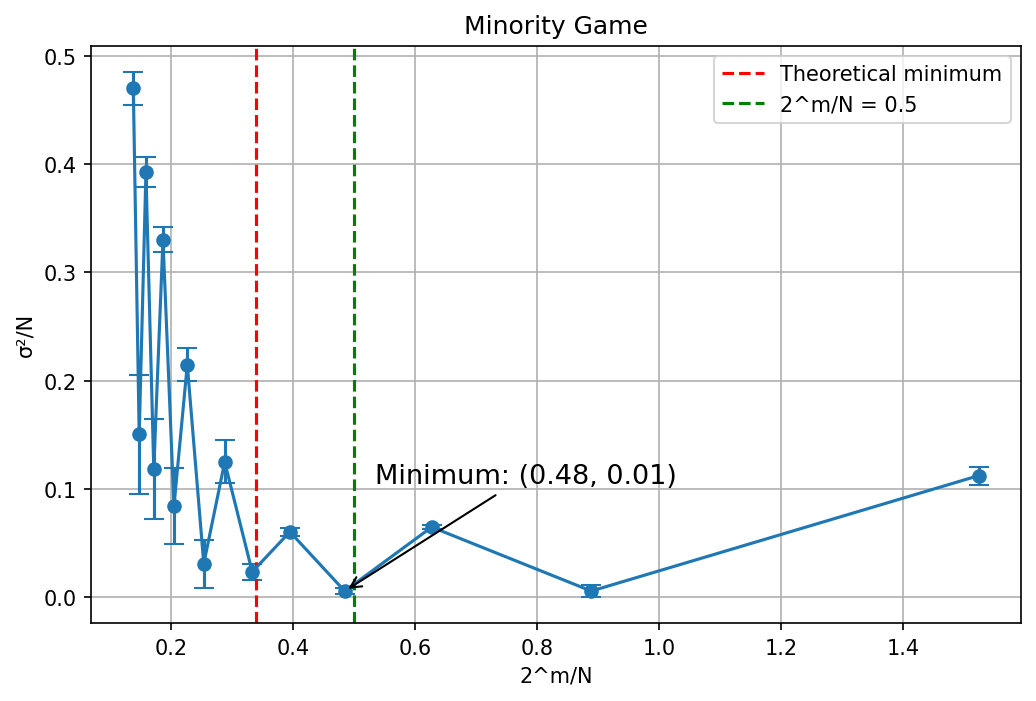

In [5]:
plt.figure(figsize=(8, 5), dpi=150)
plt.errorbar(xs, sigmas, yerr=errors, fmt='o-', capsize=5)
plt.xlabel('2^m/N')
plt.ylabel('σ²/N')
plt.title('Minority Game')
plt.axvline(x=0.34, color='r', linestyle='--', label='Theoretical minimum')
plt.axvline(x=0.5, color='g', linestyle='--', label='2^m/N = 0.5')

min_idx = np.argmin(sigmas)
min_x, min_y = xs[min_idx], sigmas[min_idx]
plt.annotate(f'Minimum: ({min_x:.2f}, {min_y:.2f})', xy=(min_x, min_y), xytext=(min_x + 0.05, min_y + 0.1), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=13)
plt.grid(True)
plt.legend()
plt.show()

The result of this simulation has its global minimum at $2^{m}/{N} \approx 0.48$(when $N=66$), which is close to 0.5, this is might be caused by the finite size effect of simulations, even if I tried to increase $nsam$ to 50. But we can still see from the plot that the value of $\sigma^{2}/{N}$ at $2^{m}/{N} = 0.34$ is close to global minimum and is a local minimum. 